![photo-1516937941344-00b4e0337589](photo-1516937941344-00b4e0337589.jpg)

## Background
With increasing amounts of carbon emissions worldwide, scientists and nations alike are witnessing the effects of increased carbon emissions. Escalating natural disasters, such as hurricanes, due to climate change, the destruction of several habitats, and the endangerment of many species due to this phenomenon have forced scientists and nations to recognize the danger of climate change. Many developed countries, such as the United States, blame developing countries for the rise of carbon emissions globally. However, many developed nations have reached a point where they no longer need carbon emissions for economic success. Notably, the United States heavily relied on the industry throughout the 19th and early 20th centuries to reach financial independence and global influence. This project aims to analyze developed countries' previous dependence on carbon emissions for economic prosperity toward the necessity of increasing carbon emissions for developing countries to gain developmental and financial independence. 

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   
sns.set_style('whitegrid')

In [50]:
# Clean data
cemissions = pd.read_csv('annual-co2-emissions-per-country.csv')
cemissions = cemissions.drop(['Code'], axis=1)
# print(cemissions.isna().value_counts - No missing values

gdp = pd.read_csv('gdp-per-capita-maddison-2020.csv')
# print(gdp['417485-annotations'].describe()) 
# print(gdp.isna().value_counts()) - No missing values after drop
gdp = gdp.drop(['Code', '417485-annotations'], axis=1)
gdp = gdp.drop(gdp.loc[gdp['Year'] < 1800, 'Year'].index, axis=0)
cemissions = cemissions.drop(cemissions.loc[(cemissions['Year'] < 1800) | (cemissions['Year'] > 2018), 'Year'].index, axis=0)
cemissions.columns = cemissions.columns.str.replace('Annual CO₂ emissions', 'CO2 emissions')

## 🇬🇧 United Kingdom
One of the first nations in the world to industrialize, the United Kingdom rose to power in a Victorian Age of British influence, prosperity, and colonialism. During this age, the UK relied on heavy industry, with the smoke of such processes even changing the evolution of several species of moths, reflecting the sheer amount of carbon emitted during this time. To confirm this, it is necessary to visualize the correlation between GDP growth and CO2 emissions during Britain's industrial growth, ranging from 1760 to 1840. However, there is limited data before 1800, so the data will be limited to 1800-1840. 

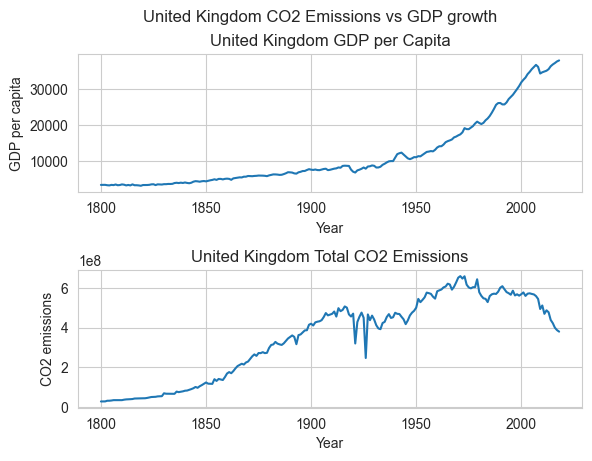

In [51]:
# Provide basic vizualization of initial data
UKG = gdp[gdp['Entity'] == 'United Kingdom']
UKC = cemissions[cemissions['Entity'] == 'United Kingdom']
fig, ax = plt.subplots(nrows=2)
fig.tight_layout(pad=3.5)
fig.suptitle('United Kingdom CO2 Emissions vs GDP growth')
ax[0].set_title('United Kingdom GDP per Capita')
ax[1].set_title('United Kingdom Total CO2 Emissions')
sns.lineplot(data=UKG, x='Year', y='GDP per capita', ax=ax[0])
sns.lineplot(data=UKC, x='Year', y='CO2 emissions', ax=ax[1])
UnitedKingdom = UKG.merge(UKC, on='Year')
UnitedKingdom = UnitedKingdom.drop(['Entity_x', 'Entity_y'], axis=1)
def limit_country(country): 
    GDP = gdp[gdp['Entity'] == country]
    CC = cemissions[cemissions['Entity'] == country]
    return GDP.merge(CC, on='Year').drop(['Entity_x', 'Entity_y'], axis=1)                                  

<AxesSubplot: xlabel='GDP per capita', ylabel='CO2 emissions'>

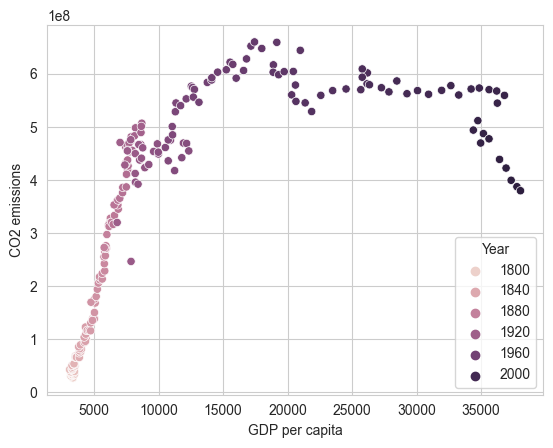

In [52]:
sns.scatterplot(data=UnitedKingdom, x='GDP per capita', y='CO2 emissions', hue='Year')

# From what we can see here, general dependence on CO2 emissions towards earlier GDP per capita and decends later on

Through these two visualizations, it is evident that the UK had a significant period of economic growth during its Industrial Revolution, with a period of increased carbon emissions following early periods of growth. However, this trend began to decrease towards the early 20th century. This is likely due to the advancement of the United Kingdom in later years and their overall increase in the diversity of economic sectors, transitioning into "an economy in which knowledge, information, and services are more valuable than manufacturing" (Cambridge Dictionary). Thus, limiting the data to the period in which that development occurred is necessary to accurately picture the necessity of carbon emissions during a country's development period. Again, this period lies from 1800-1840 in our dataset for Britain.

<AxesSubplot: title={'center': 'UK GDP vs Total CO2 Emissions'}, xlabel='GDP per capita', ylabel='CO2 emissions'>

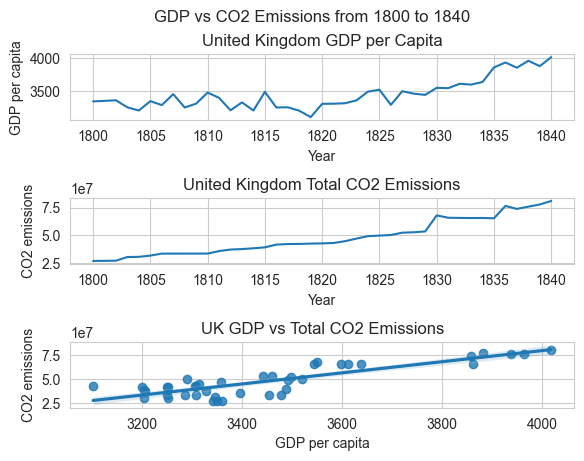

In [53]:
UnitedKingdomIR = UnitedKingdom[UnitedKingdom['Year'] <= 1840]
fig, ax = plt.subplots(nrows=3)
fig.tight_layout(pad=3.5)
fig.suptitle('GDP vs CO2 Emissions from 1800 to 1840')
ax[0].set_title('United Kingdom GDP per Capita')
ax[1].set_title('United Kingdom Total CO2 Emissions')
ax[2].set(title='UK GDP vs Total CO2 Emissions')
sns.lineplot(data=UnitedKingdomIR, x='Year', y='GDP per capita', ax=ax[0])
sns.lineplot(data=UnitedKingdomIR, x='Year', y='CO2 emissions', ax=ax[1])
sns.regplot(data=UnitedKingdomIR, x='GDP per capita', y='CO2 emissions', ax=ax[2])

0.6798746633365375


<AxesSubplot: xlabel='GDP per capita', ylabel='CO2 emissions'>

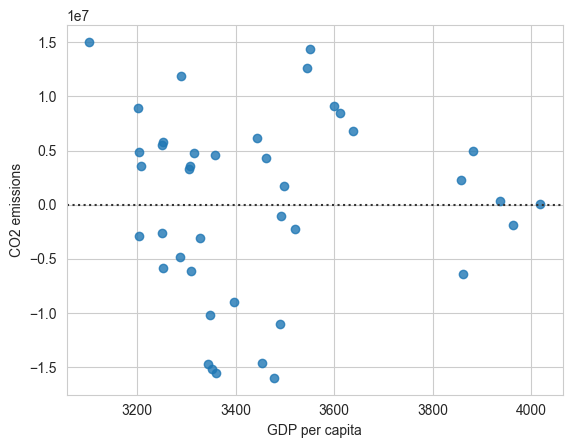

In [54]:
print(UnitedKingdom['GDP per capita'].corr(UnitedKingdom['CO2 emissions']))

# Confirm that the relationship is linear
sns.residplot(data=UnitedKingdomIR, x='GDP per capita', y='CO2 emissions')

The correlation between GDP per capita and CO2 Emissions during this period was: -0.692549976021929


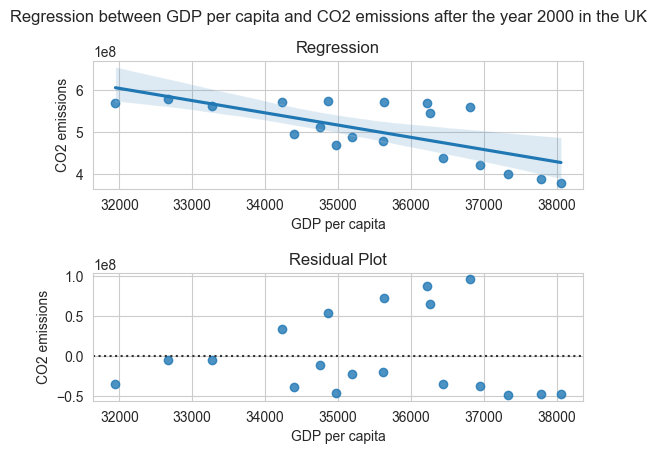

In [68]:
UnitedKingdom2 = UnitedKingdom[(UnitedKingdom['Year'] >= 2000)]

# Visualize US data
fig, ax = plt.subplots(nrows=2)
fig.tight_layout(pad=4)
fig.suptitle('Regression between GDP per capita and CO2 emissions after the year 2000 in the UK')
ax[0].set(title='Regression')
ax[1].set(title='Residual Plot')
sns.regplot(data=UnitedKingdom2, x='GDP per capita', y='CO2 emissions', ax=ax[0])
sns.residplot(data=UnitedKingdom2, x='GDP per capita', y='CO2 emissions', ax=ax[1])
print("The correlation between GDP per capita and CO2 Emissions during this period was:", UnitedKingdom2['GDP per capita'].corr(UnitedKingdom2['CO2 emissions']))

It can be concluded that the United Kingdom had a strong and linear correlation between economic growth and increases in carbon emissions during its period of industrial development. The regression and residual plot prove that the United Kingdom relied on carbon emissions to reach a stable state of growth and economic prosperity. However, after the period of significant industrialization, the UK saw a strong negative correlation between GDP and carbon emissions, suggesting that decreases in carbon emissions and diversification of the British economy resulted in recent economic growth.

## 🇺🇸 United States
The United States is renowned for its industrial growth during its Gilded Age. Despite the harsh treatment of workers, the United States saw a period of rapid growth that shook the world, placing the US as a leader on the world stage. Sources consistently label this period between 1865 and 1898, enabling analysis of the necessity of carbon emissions for economic development in one of the most prosperous nations in the world.

The correlation between GDP per capita and CO2 Emissions during the US' Gilded Age was: 0.9377444998740774


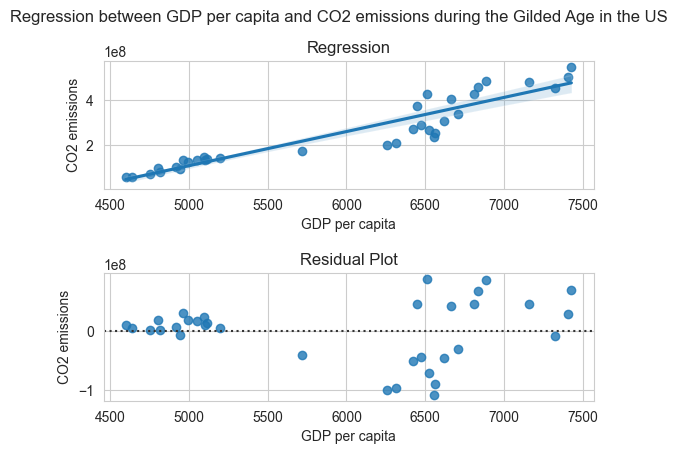

In [55]:
USG = gdp[gdp['Entity'] == 'United States']
USC = cemissions[cemissions['Entity'] == 'United States']
UnitedStates = USG.merge(USC, on='Year')
UnitedStates = UnitedStates.drop(['Entity_x', 'Entity_y'], axis=1)
# Gilded age was from 1865-1898              
UnitedStatesGA = UnitedStates[(UnitedStates['Year'] >= 1865) & (UnitedStates['Year'] <= 1898)]

# Visualize US data
fig, ax = plt.subplots(nrows=2)
fig.tight_layout(pad=4)
fig.suptitle('Regression between GDP per capita and CO2 emissions during the Gilded Age in the US')
ax[0].set(title='Regression')
ax[1].set(title='Residual Plot')
sns.regplot(data=UnitedStatesGA, x='GDP per capita', y='CO2 emissions', ax=ax[0])
sns.residplot(data=UnitedStatesGA, x='GDP per capita', y='CO2 emissions', ax=ax[1])
print("The correlation between GDP per capita and CO2 Emissions during the US' Gilded Age was:", UnitedStatesGA['GDP per capita'].corr(UnitedStatesGA['CO2 emissions']))

The correlation between GDP per capita and CO2 Emissions during this period was: -0.6517875330334366


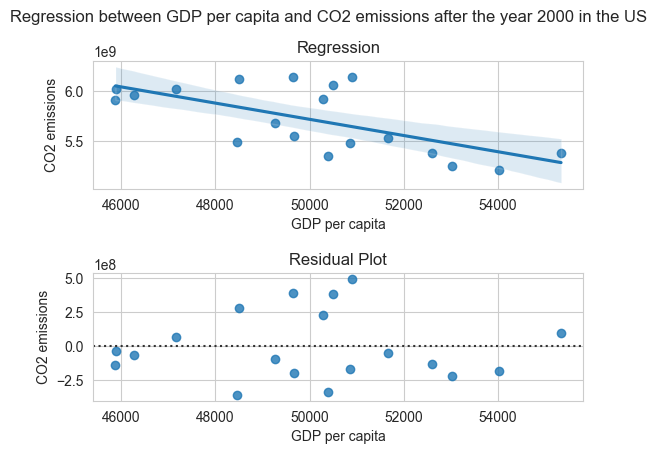

In [63]:
USG = gdp[gdp['Entity'] == 'United States']
USC = cemissions[cemissions['Entity'] == 'United States']
UnitedStates = USG.merge(USC, on='Year')
UnitedStates = UnitedStates.drop(['Entity_x', 'Entity_y'], axis=1)
UnitedStatesGA = UnitedStates[(UnitedStates['Year'] >= 2000)]

# Visualize US data
fig, ax = plt.subplots(nrows=2)
fig.tight_layout(pad=4)
fig.suptitle('Regression between GDP per capita and CO2 emissions after the year 2000 in the US')
ax[0].set(title='Regression')
ax[1].set(title='Residual Plot')
sns.regplot(data=UnitedStatesGA, x='GDP per capita', y='CO2 emissions', ax=ax[0])
sns.residplot(data=UnitedStatesGA, x='GDP per capita', y='CO2 emissions', ax=ax[1])
print("The correlation between GDP per capita and CO2 Emissions during this period was:", UnitedStatesGA['GDP per capita'].corr(UnitedStatesGA['CO2 emissions']))

It is reasonable to conclude that there was a strong correlation between carbon emissions and growth in GDP during the Gilded Age for the United States. Overall, the residual plot does not display a predicted dispersion among the points, with a fairly congregated section of points towards the lower end of GDP. This likely reflects an abnormally strong correlation between these two variables during the early periods of the Gilded Age. However, this congregation may signify the inability of a linear regression model to depict the relation between these two variables. Nevertheless, due to the overwhelming possibility of simply a stronger correlation during this section, it can be assumed that this was not the case. Additionally, with the strong negative correlation between GDP and carbon emissions during the modern period, it is evident that the US economy has grown in recent years as it strayed away from carbon-emitting processes. 

## 🇨🇳 China 
In the modern world, China is one of the most influential and economically prominent nations in the world, inching closer to the US in terms of economic prosperity. This economic success, however, was not without a price. China is well known for the previous Maoist focus on industrialization and urbanization, forcing many citizens into the cities to promote industrial growth, similar to the Soviet economic model. As with other nations, heavy industry requires processes that emit incredible amounts of carbon into the atmosphere. This Maoist focus on industrialization, according to Li Xiaoyun, occurred from 1953 to 1978. 

The linear correlation between GDP per capita and CO2 Emissions during the Chinese period of growth was: 0.8125568115066756


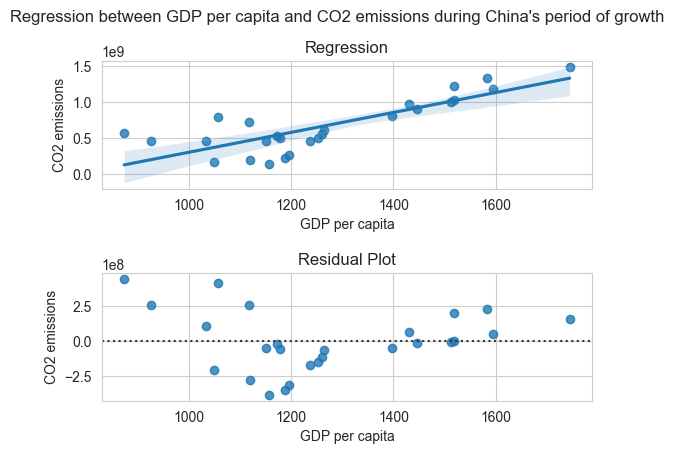

In [56]:
# Chinese major switch to heavy industry: 1953 to 1978
China = limit_country('China')
ChinaIR = China[(China['Year'] >= 1953) & (China['Year'] <= 1978)]

fig, ax = plt.subplots(nrows=2)
fig.tight_layout(pad=4)
fig.suptitle("Regression between GDP per capita and CO2 emissions during China's period of growth")
ax[0].set(title='Regression')
ax[1].set(title='Residual Plot')
sns.regplot(data=ChinaIR, x='GDP per capita', y='CO2 emissions', ax=ax[0])
sns.residplot(data=ChinaIR, x='GDP per capita', y='CO2 emissions', ax=ax[1])
print("The linear correlation between GDP per capita and CO2 Emissions during the Chinese period of growth was:", ChinaIR['GDP per capita'].corr(ChinaIR['CO2 emissions']))

By confirming a linear relationship through the regression and residual plot, it is reasonable to conclude that China had a strong relationship between economic growth and carbon emissions during its period of industrial development. However, it should be noted that the Chinese had a weaker correlation than the US and the UK. Thus, in their quest to achieve economic dominance to a point where they could compete with even the United States, the Chinese relied on carbon emissions to industrialize and succeed.

## Insight into industrialized powers
Concerning the proven necessity of carbon emissions for economic growth in these global superpowers, it can be accurately concluded that these powers relied on carbon-emitting processes to industrialize to a point where they could begin to diversify their economy. These overwhelmingly strong correlations attest that nations require carbon emissions to start their initial developments and lessen their reliance on such processes. These nations are now regarded as some of the wealthiest countries with the highest living standards and least dependence on carbon-emitting processes to grow their economy. However, they required such methods to reach a point of independence and prominence.

## 🇳🇬 Nigeria
Despite the rough colonial period in Nigeria's past, Nigeria has developed into a valued power throughout the globe, becoming the 32nd largest economy in the world. Nigeria began to industrialize after achieving independence and obtaining stability after their civil war. However, most of Nigeria's current success resulted from an oil boom that allowed for a seemingly endless stream of capital into the country. The profitability of natural resources in Nigeria, the cost of industrialization, and the country's political instability have resulted in the stalling of Nigeria's industrialization. Due to this, the data will be limited to after the year 1980 until the present.

The linear correlation between GDP per capita and CO2 Emissions during Nigeria's period of growth was: 0.8451402478944819


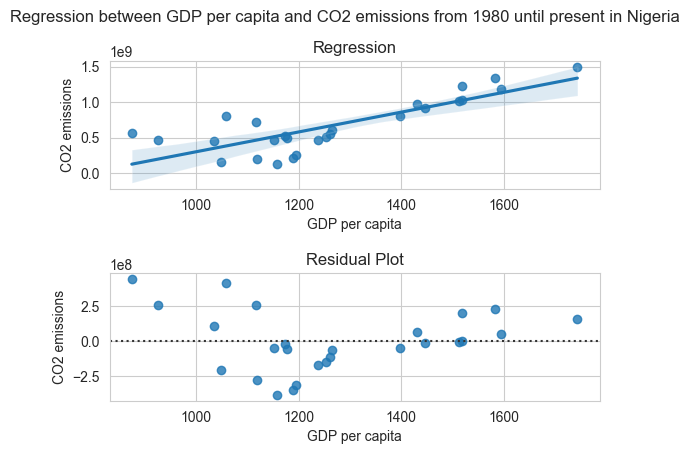

In [57]:
# Nigeria industrial growth from 1980 to present. 
Nigeria = limit_country('Nigeria')
NigeriaIG = Nigeria[(Nigeria['Year'] >= 1980)]

fig, ax = plt.subplots(nrows=2)
fig.tight_layout(pad=4)
fig.suptitle("Regression between GDP per capita and CO2 emissions from 1980 until present in Nigeria")
ax[0].set(title='Regression')
ax[1].set(title='Residual Plot')
sns.regplot(data=ChinaIR, x='GDP per capita', y='CO2 emissions', ax=ax[0])
sns.residplot(data=ChinaIR, x='GDP per capita', y='CO2 emissions', ax=ax[1])
print("The linear correlation between GDP per capita and CO2 Emissions during Nigeria's period of growth was:", NigeriaIG['GDP per capita'].corr(NigeriaIG['CO2 emissions']))

## 🇮🇩 Indonesia
Following the grasp of colonialism (Indonesia was under the rule of the Dutch until 1949), Indonesia's economy had a significant focus on agrarianism, pushing off industrialization until 1967 through a process that lasted until around 2009. Now, being number 83 in the world in terms of GDP per capita and an HDI of 0.707 as of 2018, Indonesia is an emerging power with steady economic growth, making it a great candidate to look into. 

The linear correlation between GDP per capita and CO2 Emissions during Indonesia's period of growth was: 0.9849152703287573


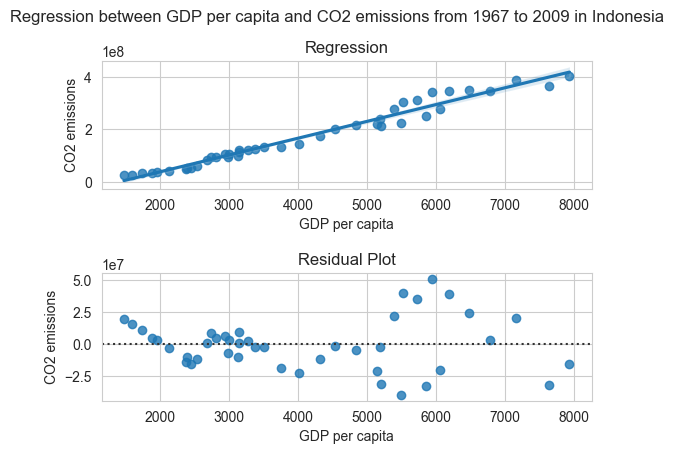

In [58]:
Indonesia = limit_country('Indonesia')
# From 1967 to 2009
IndonesiaI = Indonesia[(Indonesia['Year'] >= 1967) & (Indonesia['Year'] <= 2009)]
fig, ax = plt.subplots(nrows=2)
fig.tight_layout(pad=4)
fig.suptitle("Regression between GDP per capita and CO2 emissions from 1967 to 2009 in Indonesia")
ax[0].set(title='Regression')
ax[1].set(title='Residual Plot')
sns.regplot(data=IndonesiaI, x='GDP per capita', y='CO2 emissions', ax=ax[0])
sns.residplot(data=IndonesiaI, x='GDP per capita', y='CO2 emissions', ax=ax[1])
print("The linear correlation between GDP per capita and CO2 Emissions during Indonesia's period of growth was:", IndonesiaI['GDP per capita'].corr(IndonesiaI['CO2 emissions']))

Mostly linear correlation with clustering at the first quarter of the plot. 

Text(0.5, 1.0, 'CO2 emissions')

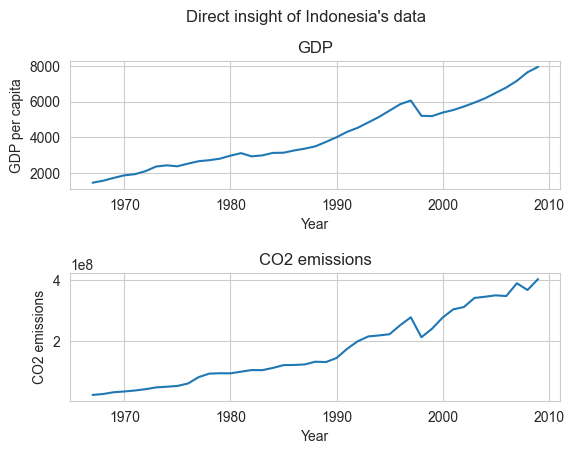

In [59]:
fig, ax = plt.subplots(nrows=2)
fig.tight_layout(pad=4)
fig.suptitle("Direct insight of Indonesia's data")
ax[0] = sns.lineplot(data=IndonesiaI, x='Year', y='GDP per capita', ax=ax[0])
ax[1] = sns.lineplot(data=IndonesiaI, x='Year', y='CO2 emissions', ax=ax[1])
ax[0].set_title('GDP')
ax[1].set_title('CO2 emissions')

The clustering found in the residual plot reflects a stronger correlation between CO2 emissions and GDP growth during the industrialization period of Indonesia. The correlation variable shown for Indonesia between CO2 emissions and GDP was 0.98, displaying a solid, positive correlation between CO2 emissions and GDP for Indonesia. This affirms the idea that developing countries rely on carbon emissions to jumpstart their economies and take their place in the world. 

## 🇧🇷 Brazil
Brazil is considered by many to have a significant place in the world, with its place 51 in the world in terms of GDP per capita. However, as with many other Latin American countries, Brazil was previously in a considerable period of agricultural dependence. However, as Brazil began its period of industrialization around 1950, lasting until around 1970, the period between 1950 and 1975 will be used for analysis. Knowing how such a previously dependent country became independent from its colonizers and raw resources is worth looking into, especially how they could industrialize and grow their economy at such a pace.

The linear correlation between GDP per capita and CO2 Emissions during Brazil's period of growth was: 0.9941664554595867


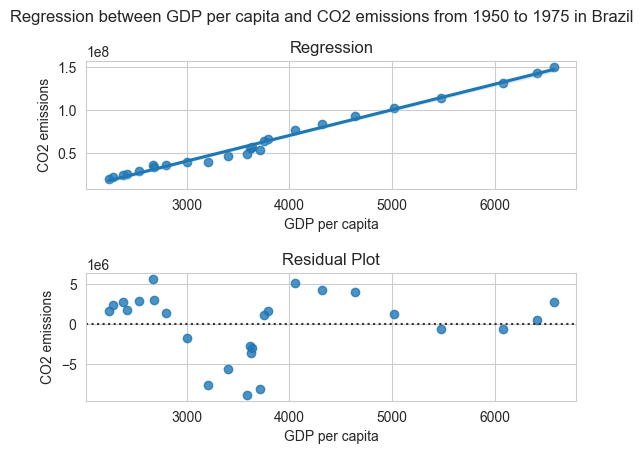

In [60]:
Brazil = limit_country('Brazil')
# From 1967 to 2009
BrazilIR = Brazil[(Brazil['Year'] >= 1950) & (Brazil['Year'] <= 1975)]
fig, ax = plt.subplots(nrows=2)
fig.tight_layout(pad=4)
fig.suptitle("Regression between GDP per capita and CO2 emissions from 1950 to 1975 in Brazil")
ax[0].set(title='Regression')
ax[1].set(title='Residual Plot')
sns.regplot(data=BrazilIR, x='GDP per capita', y='CO2 emissions', ax=ax[0])
sns.residplot(data=BrazilIR, x='GDP per capita', y='CO2 emissions', ax=ax[1])
print("The linear correlation between GDP per capita and CO2 Emissions during Brazil's period of growth was:", BrazilIR['GDP per capita'].corr(BrazilIR['CO2 emissions']))

Although Brazil remains in its process of development, the topic of Brazil becoming a significant superpower has come up as experts begin to realize the immense potential of Brazil. The data shows that Brazil has relied heavily on CO2 emissions to increase GDP, with a correlation between the two variables of 0.994, reflecting an extremely strong positive correlation. This means that, alongside other developing countries, Brazil relied on carbon-emitting processes to grow its economy, becoming the 10th largest economy in the world and starting to diversify its economy away from exporting raw resources into the service industry, tourism, and more. This transition, as proven similarly by the other countries listed, would not have been possible without carbon-emitting processes.

## Insight into emerging powers
Looking back at the robust positive correlations between GDP and CO2 emissions in the industry-focused periods of these countries' history, it is resonable to infer that for a country to succeed and diversify its economy, it first needs to industrialize its economy through carbon-emitting processes. Once these countries have a solid foundation and stable economy, they can begin transforming and diversifying their economy to create a more stable country and establish their place in the world. From these results, it is clear that developing countries cannot have their access to opportunities through carbon-emitting processes revoked by major powers lest they are forced into stagnation and even collapse. 

## Conclusion
Through the proven dependence of all of these countries, developed and emerging powers alike, on carbon-emitting processes to achieve economic diversification and success, the evidence provided supports a conclusion that such processes are necessary for developing countries to achieve stability. For now and in the foreseeable future, carbon-emitting processes are the only pathway many developing countries have to prosperity and sustainable peace. Thus, carbon emissions remain necessary for many countries to succeed until more profitable and effective ways of jumpstarting a country with limited infrastructure and existing economic options emerge.  

Rather than penalizing developing countries for their carbon emissions and preventing them from achieving success, developed superpowers should attempt to resort to more manageable approaches to the issue. This could range from instructing developing countries on achieving a state of industrilization with minimal emissions or focusing on their own emitting processes. The severity of climate change should not be understated, but the effects of mass poverty and hunger among countries not yet developed is on an arguably equal scale of necessity. 

This study focuses on periods of industrialization. However, as proven by the UK and US, it is clear that after a country has fully industrialized, diversification of the economy is very profitable and necessary. Thus, it is beneficial for developed countries to reduce their carbon emissions to aid the climate crisis, achieve economic success, and create long-lasting stability.

### Author: Parker Allen


## References

Brazil as an economic superpower? Understanding Brazil’s changing role in the global economy. (2016, July 29). Brookings.       https://www.brookings.edu/events/brazil-as-an-economic-superpower-understanding-brazils-changing-role-in-the-global-economy/

CO2 emissions. (n.d.). Our World in Data. https://ourworldindata.org/co2-emissions

The complex effects of colonial rule in Indonesia. (n.d.). MIT News | Massachusetts Institute of Technology. https://news.mit.edu/2020/sugar-factories-colonial-indonesia-olken-dell-0206

Country insights. (n.d.). Human Development Reports. https://hdr.undp.org/data-center/country-insights#/ranks

Elias, S., & Noone, C. (2011, December). The Growth and Development of the Indonesian Economy. https://www.rba.gov.au/publications/bulletin/2011/dec/pdf/bu-1211-4.pdf

GDP per capita - Data quality rankings. (n.d.). World Economics. https://www.worldeconomics.com/Rankings/Wealth-Data-Quality-Ratings.aspx

GDP per capita. (n.d.). Our World in Data. https://ourworldindata.org/grapher/gdp-per-capita-maddison-2020?tab=chart&country=Western+Europe~Western+Offshoots~East+Asia~South+and+South-East+Asia~Middle+East~Eastern+Europe~Latin+America~Sub-Sahara+Africa~OWID_WRL~AFG~GBR

Indonesia breaks into high human development category group | United Nations development programme. (2019, December 10). UNDP. https://www.undp.org/indonesia/press-releases/indonesia-breaks-high-human-development-category-group

Industrial Revolution. (n.d.). Encyclopedia Britannica. https://www.britannica.com/event/Industrial-Revolution

Information economy. (n.d.). Cambridge Dictionary | English Dictionary, Translations & Thesaurus. https://dictionary.cambridge.org/us/dictionary/english/information-economy

Introduction to the gilded age (video). (n.d.). Khan Academy. https://www.khanacademy.org/humanities/us-history/the-gilded-age/gilded-age/v/the-gilded-age-part-1

Nigeria economy ranking: By GDP and 60 other indicators. (2020, May 11). Georank.org. https://georank.org/economy/nigeria

Pilatti, L. A. (2018, June 16). Brazilian industrialization according to its technologies intensities. Sistema de Información Científica Redalyc, Red de Revistas Científicas. https://www.redalyc.org/journal/2150/215057003001/html/

Xiaoyun, L. (2014, November 20). China's Industrialization: Overview. tralac trade law centre. **https://www.tralac.org/images/docs/6676/background-report-chinas-industrialization-overview.pdf**